In [ ]:
!pip install PyDrive

In [ ]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
download = drive.CreateFile({'id': '1iIfIwZZv8ZxSUjgN08VOez5reVJ6zFpN'})
download.GetContentFile('train.zip')

In [ ]:
!unzip train.zip

In [ ]:
#Importing fastai will also import numpy, pytorch, etc. 
from fastai.vision import *
from numbers import Integral
import seaborn as sns

In [ ]:
#Modified from 
K=2
class MultiTransformLabelList(LabelList):
    def __getitem__(self,idxs:Union[int,np.ndarray])->'LabelList':
        "return a single (x, y) if `idxs` is an integer or a new `LabelList` object if `idxs` is a range."
        idxs = try_int(idxs)
        if isinstance(idxs, Integral):
            if self.item is None: x,y = self.x[idxs],self.y[idxs]
            else:                 x,y = self.item   ,0
            if self.tfms or self.tfmargs:
                #I've changed this line to return a list of augmented images
                x = [x.apply_tfms(self.tfms, **self.tfmargs) for _ in range(K)]
            if hasattr(self, 'tfms_y') and self.tfm_y and self.item is None:
                y = y.apply_tfms(self.tfms_y, **{**self.tfmargs_y, 'do_resolve':False})
            if y is None: y=0
            return x,y
        else: return self.new(self.x[idxs], self.y[idxs])
        
#I'll also need to change the default collate function to accomodate multiple augments
def MixmatchCollate(batch):
    batch = to_data(batch)
    if isinstance(batch[0][0],list):
        batch = [[torch.stack(s[0]),s[1]] for s in batch]
    return torch.utils.data.dataloader.default_collate(batch)

In [ ]:
#Grab file path to cifar dataset. Will download data if not present
path = "/content/satellite_MixMatch"

#Custom ImageList with filter function
class MixMatchImageList(ImageList):
    def filter_train(self,num_items,seed=2343):
        train_idxs = np.array([i for i,o in enumerate(self.items) if Path(o).parts[-3] != "test"])
        valid_idxs = np.array([i for i,o in enumerate(self.items) if Path(o).parts[-3] == "test"])
        np.random.seed(seed)
        keep_idxs = np.random.choice(train_idxs,num_items,replace=False)
        self.items = np.array([o for i,o in enumerate(self.items) if i in np.concatenate([keep_idxs,valid_idxs])])
        return self
    
#Create two databunch objects for the labeled and unlabled images. A fastai databunch is a container for train, validation, and
#test dataloaders which automatically processes transforms and puts the data on the gpu.
data_labeled = (MixMatchImageList.from_folder(path)
                .filter_train(500) #Use 500 labeled images for traning
                .split_by_folder(valid="test") #test on all 6000 images in test set
                .label_from_folder()
                .transform(get_transforms(xtra_tfms=[cutout(n_holes=(2,3), length=(5, 10), p=.4)]),size=32)
                #On windows, must set num_workers=0. Otherwise, remove the argument for a potential performance improvement
                .databunch(bs=64,num_workers=0)
                .normalize(cifar_stats))

train_set = set(data_labeled.train_ds.x.items)
src = (ImageList.from_folder(path)
        .filter_by_func(lambda x: x not in train_set)
        .split_by_folder(valid="test"))
src.train._label_list = MultiTransformLabelList
data_unlabeled = (src.label_from_folder()
         .transform(get_transforms(xtra_tfms=[cutout(n_holes=(2,3), length=(5, 10), p=.4)]),size=32)
         .databunch(bs=128,collate_fn=MixmatchCollate,num_workers=0)
         .normalize(cifar_stats))

#Databunch with all 50k images labeled, for baseline
data_full = (ImageList.from_folder(path)
        .split_by_folder(valid="test")
        .label_from_folder()
        .transform(get_transforms(xtra_tfms=[cutout(n_holes=(2,3), length=(5, 10), p=.4)]),size=32)
        .databunch(bs=128,num_workers=0)
        .normalize(cifar_stats))

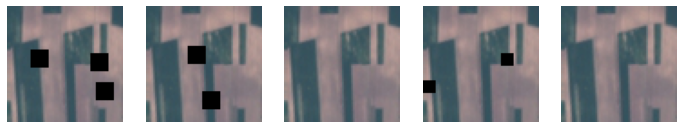

In [ ]:
def get_ex(): return open_image('/content/satellite_MixMatch/train/AnnualCrop/AnnualCrop_1001.jpg')

tfms = [cutout(n_holes=(2,3), length=(5, 10), p=.4)]
fig, axs = plt.subplots(1,5,figsize=(12,4))
for ax in axs:
    get_ex().apply_tfms(tfms).show(ax=ax)

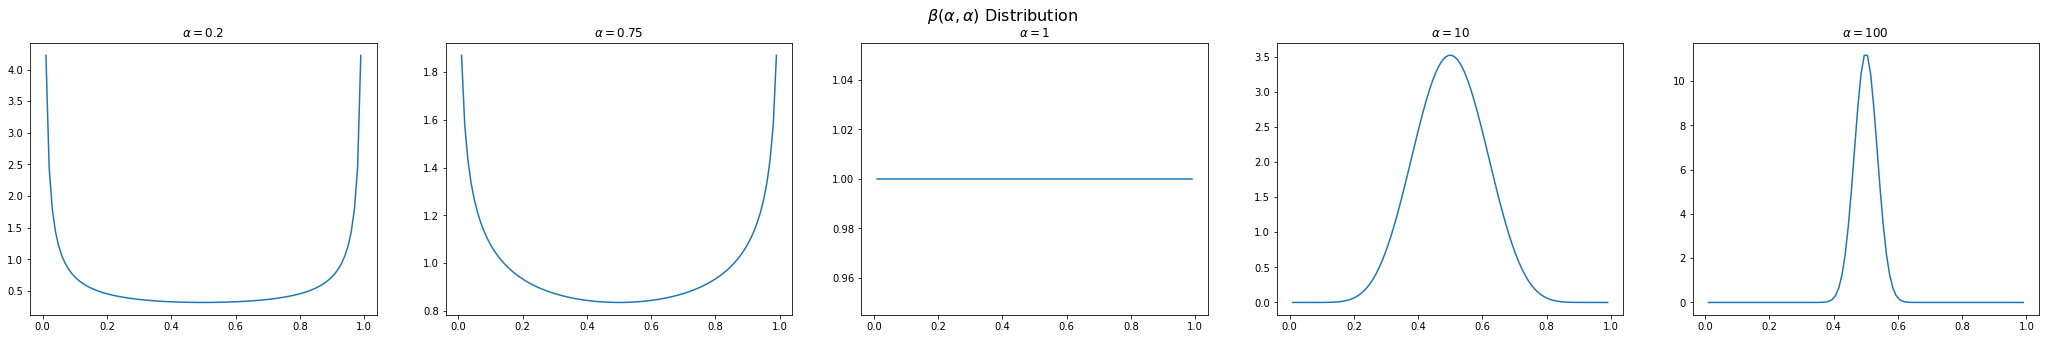

In [ ]:
from scipy.stats import beta
x = np.linspace(0.01,0.99, 100)
fig, axes = plt.subplots(1,5,figsize=(36,5))
fig.suptitle(r"$\beta(\alpha,\alpha)$ Distribution",fontsize=16)
alphas = [0.2,0.75,1,10,100]
for a, ax in zip(alphas,axes.flatten()):
    ax.set_title(r"$\alpha={}$".format(a))
    ax.plot(x, beta.pdf(x, a, a))

In [ ]:
def mixup(a_x,a_y,b_x,b_y,alpha=0.75):
    l = np.random.beta(alpha,alpha)
    l = max(l,1-l)
    x = l * a_x + (1-l) * b_x
    y = l* a_y + (1-l) * b_y
    return x,y

In [ ]:
def sharpen(p,T=0.5):
    u = p ** (1/T)
    return u / u.sum(dim=1,keepdim=True)

In [ ]:
class MixupLoss(nn.Module):
    def forward(self, preds, target, unsort=None, ramp=None, bs=None):
        if unsort is None:
            return F.cross_entropy(preds,target)
        preds = preds[unsort]
        preds_l = preds[:bs]
        preds_ul = preds[bs:]
        preds_l = torch.log_softmax(preds_l,dim=1)
        preds_ul = torch.softmax(preds_ul,dim=1)
        loss_x = -(preds_l * target[:bs]).sum(dim=1).mean()
        loss_u = F.mse_loss(preds_ul,target[bs:])
        self.loss_x = loss_x.item()
        self.loss_u = loss_u.item()
        return loss_x + 100 * ramp * loss_u

In [ ]:
class MixMatchTrainer(LearnerCallback):
    _order=-20
    def on_train_begin(self, **kwargs):
        self.l_dl = iter(data_labeled.train_dl)
        self.smoothL, self.smoothUL = SmoothenValue(0.98), SmoothenValue(0.98)
        self.recorder.add_metric_names(["l_loss","ul_loss"])
        self.it = 0
        
    def on_batch_begin(self, train, last_input, last_target, **kwargs):
        if not train: return
        try:
            x_l,y_l = next(self.l_dl)
        except:
            self.l_dl = iter(data_labeled.train_dl)
            x_l,y_l = next(self.l_dl)
            
        x_ul = last_input
        
        with torch.no_grad():
            ul_labels = sharpen(torch.softmax(torch.stack([self.learn.model(x_ul[:,i]) for i in range(x_ul.shape[1])],dim=1),dim=2).mean(dim=1))
            
        x_ul = torch.cat([x for x in x_ul])
        ul_labels = torch.cat([y.unsqueeze(0).expand(K,-1) for y in ul_labels])
        
        l_labels = torch.eye(data_labeled.c).cuda()[y_l]
        
        w_x = torch.cat([x_l,x_ul])
        w_y = torch.cat([l_labels,ul_labels])
        idxs = torch.randperm(w_x.shape[0])
        
        mixed_input, mixed_target = mixup(w_x,w_y,w_x[idxs],w_y[idxs])
        bn_idxs = torch.randperm(mixed_input.shape[0])
        unsort = [0] * len(bn_idxs)
        for i,j in enumerate(bn_idxs): unsort[j] = i
        mixed_input = mixed_input[bn_idxs]
    

        ramp = self.it / 3000.0 if self.it < 3000 else 1.0
        return {"last_input": mixed_input, "last_target": (mixed_target,unsort,ramp,x_l.shape[0])}
    
    def on_batch_end(self, train, **kwargs):
        if not train: return
        self.smoothL.add_value(self.learn.loss_func.loss_x)
        self.smoothUL.add_value(self.learn.loss_func.loss_u)
        self.it += 1

    def on_epoch_end(self, last_metrics, **kwargs):
        return add_metrics(last_metrics,[self.smoothL.smooth,self.smoothUL.smooth])

In [ ]:
model = models.WideResNet(num_groups=3,N=4,num_classes=10,k=2,start_nf=32)   #Wideresnet_28 (k=2) + Mixup Loss + Cutout Aug

In [ ]:
learn = Learner(data_unlabeled,model,loss_func=MixupLoss(),callback_fns=[MixMatchTrainer],metrics=accuracy)

In [ ]:
learn.fit_one_cycle(30,2e-3,wd=0.02)

epoch,train_loss,valid_loss,accuracy,l_loss,ul_loss,time
0,1.764228,1.167375,0.626000,1.719624,0.009103,03:34
1,1.629795,0.941787,0.698833,1.496055,0.012582,03:30
2,1.518787,0.812108,0.757833,1.309031,0.012610,03:28
3,1.484972,0.720519,0.780167,1.193615,0.012814,03:28
4,1.492827,0.587710,0.824333,1.134121,0.012473,03:28
5,1.477885,0.520472,0.849000,1.050910,0.012236,03:27
6,1.505665,0.461601,0.872500,1.020939,0.011806,03:29
7,1.616243,0.462405,0.866000,1.051708,0.011972,03:28
8,1.520413,0.366706,0.896833,0.949070,0.010735,03:28
9,1.452860,0.284064,0.922000,0.871362,0.009811,03:28


epoch,train_loss,valid_loss,accuracy,l_loss,ul_loss,time
0,1.444363,0.891684,0.726000,1.393030,0.011138,03:06
1,1.466905,0.864607,0.724667,1.342026,0.011885,03:05
2,1.411480,0.807668,0.737167,1.213924,0.011926,03:06
3,1.463808,0.625938,0.822833,1.185983,0.012236,03:07
4,1.479561,0.686613,0.778833,1.123005,0.012381,03:08
5,1.391629,0.466867,0.870000,1.001030,0.011191,03:07
6,1.470435,0.457521,0.877333,0.999479,0.011484,03:07
7,1.383970,0.344847,0.900000,0.913955,0.009989,03:05
8,1.444740,0.345961,0.902667,0.911239,0.010022,03:05
9,1.412779,0.311789,0.908500,0.847410,0.009530,03:05


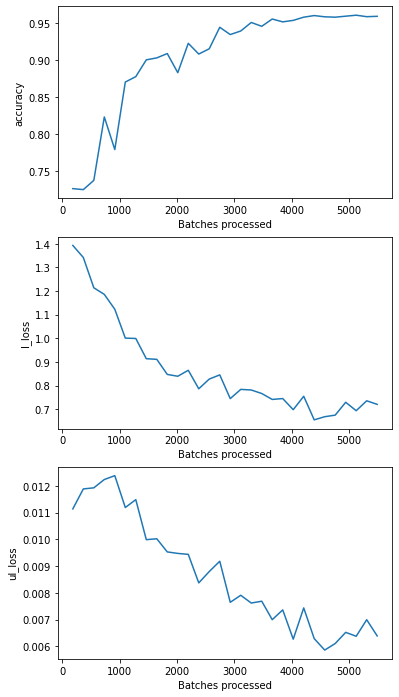

In [ ]:
model = models.WideResNet(num_groups=3,N=3,num_classes=10,k=2,start_nf=32)       #Wideresnet_22 (k=2) + Mixup Loss + Cutout Aug
learn = Learner(data_unlabeled,model,loss_func=MixupLoss(),callback_fns=[MixMatchTrainer],metrics=accuracy)
learn.fit_one_cycle(30,2e-2,wd=1e-4)
learn.recorder.plot_metrics()

epoch,train_loss,valid_loss,accuracy,l_loss,ul_loss,time
0,1.533778,0.984455,0.690000,1.486654,0.009856,04:53
1,1.440521,0.890319,0.712000,1.317390,0.011699,04:52
2,1.390074,0.754733,0.762833,1.190466,0.012027,04:51
3,1.458753,0.628477,0.831500,1.162966,0.012970,04:50
4,1.348998,0.528498,0.854500,1.012639,0.011691,04:51
5,1.491145,0.482924,0.858000,1.049022,0.012624,04:51
6,1.544479,0.516579,0.861667,1.048930,0.012076,04:49
7,1.454714,0.371573,0.901667,0.944182,0.010836,04:49
8,1.503975,0.403121,0.879833,0.940432,0.010579,04:48
9,1.562907,0.338431,0.908167,0.945126,0.010403,04:48


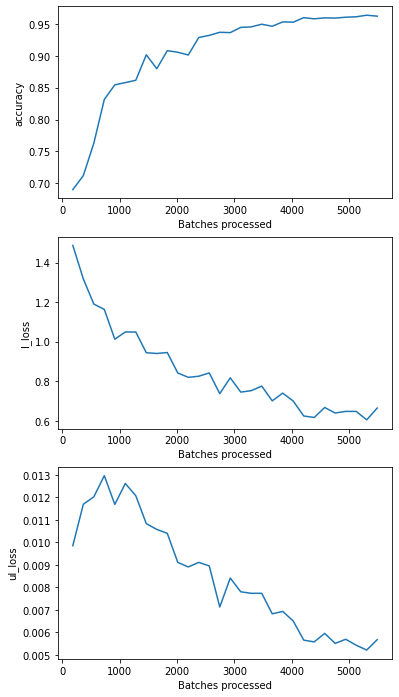

In [ ]:
model = models.WideResNet(num_groups=3,N=4,num_classes=10,k=3,start_nf=32)
learn = Learner(data_unlabeled,model,loss_func=MixupLoss(),callback_fns=[MixMatchTrainer],metrics=accuracy)   #Wideresnet_28 (k=3) + Mixup Loss + Cutout Aug
learn.fit_one_cycle(30,2e-3,wd=0.02)                       # 96.38% accuracy found in 28th epoch which is mentioned in the report
learn.recorder.plot_metrics()